In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.interpolate import RegularGridInterpolator, splrep, splev
from scipy.stats import chi2
from scipy.special import erfinv, erf
import healpy as hp
import gc
gc.enable()
from settings import *

# Get the effective areas based on "alternative_plenum_aeff.ipynb"

In [4]:
with open("./resources/tabulated_logE_sindec_aeff.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


### some settings

In [5]:
# MCEQ
with open("./resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

print(livetime)
print(gamma_astro)
print(phi_astro)

315567360.0
-2.37
1.3600000000000003e-18


## Galactic Center # todo from matthias' template fit

# Dipole

Auger: "dipole with an amplitude of $6.5^{+1.3}_{−0.9}\%$ towards right ascension $\alpha_d=100\pm10$ degrees and declination $\delta_d=−24^{+12}_{−13}$ degrees"

https://arxiv.org/abs/1709.07321

### define dipole template

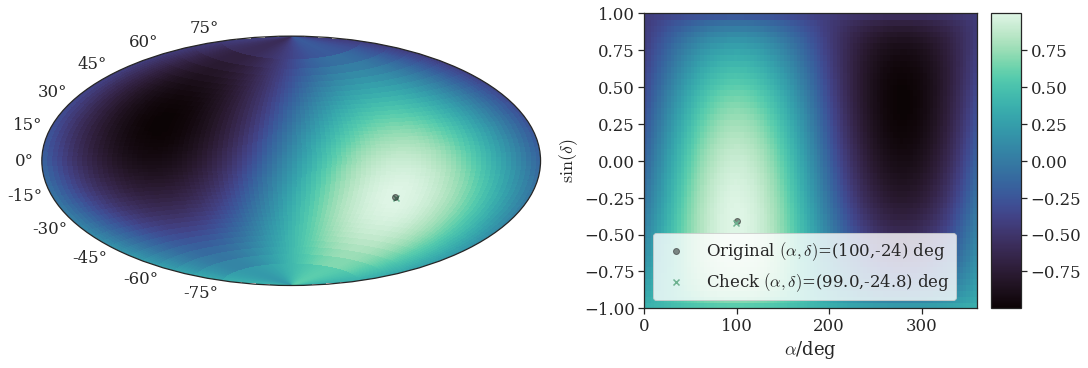

In [6]:
A_base = 0.065 # dipole amplitude

# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

# get the index of the max pixel for cross check
ira, isd = np.unravel_index(dipole.argmax(), dipole.shape)

# plot with aitoff and rectangular projection for cross check
fig = plt.figure(constrained_layout=True, figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 2])
ax = fig.add_subplot(spec[0], projection="aitoff")
ax2 = fig.add_subplot(spec[1])

# aitoff plot with coordinate trafo
ax.pcolormesh(
    *np.meshgrid(np.pi - ra_bins, np.arcsin(sindec_bins)),
    dipole.T # transpose for plotting
)
ax.scatter(np.pi-ra_mids[ira], np.arcsin(sindec_mids[isd]), marker="x")
ax.scatter(
    np.pi - alpha_d_radian, delta_d_radian,
    marker="o",
    alpha=0.5,
    color="k"
)

# rectangular plot in RA/deg and sin(dec)
im = ax2.pcolormesh(
    *np.meshgrid(np.rad2deg(ra_bins), sindec_bins),
    dipole.T # transpose for plotting
)
plt.colorbar(im, ax=ax2, aspect=30, use_gridspec=True)
# original dipole axis
ax2.scatter(
    alpha_d, np.sin(delta_d_radian),
    marker="o",
    alpha=0.5,
    color="k",
    label=r"Original $(\alpha, \delta)$=({},{}) deg".format(
        alpha_d, 
        delta_d, 
    )
)
# cross check dipole axis
ax2.scatter(
    np.rad2deg(ra_mids[ira]), sindec_mids[isd],
    marker="x", 
    label=r"Check $(\alpha, \delta)$=({:1.1f},{:1.1f}) deg".format(
        np.rad2deg(ra_mids[ira]), 
        np.rad2deg(np.arcsin(sindec_mids[isd])), 
    )
)
ax2.set_xlim(0, 360)
ax2.set_xlabel(r"$\alpha$/deg")
ax2.set_ylabel(r"$\sin(\delta)$")
ax2.legend(loc=3)
fig.savefig("./plots/dipole_test.pdf")

## Icecube energy x sindec
### comparison to diffuse (only northern) should yield ~600k events, ~2700 astro

In [7]:
# check
for det in ["IceCube", "Plenum"]:
    aeff_factor = (aeff_2d[det] * sindec_width).T * ewidth * livetime * np.sum(ra_width)
    astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 673591.4001333235
astro events: 2729.369842086181
Plenum
conv events: 2707574.9635161622
astro events: 10915.2554426219


### energy x sindec x RA

final shape: (40, 100, 50)  = energy x ra x sindec
IceCube
conv events: 673591.4001333237
astro events: 2729.369842086181
final shape: (40, 100, 50)  = energy x ra x sindec
Plenum
conv events: 2707574.9635161627
astro events: 10915.2554426219


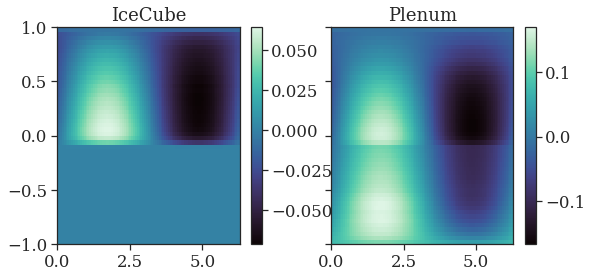

In [8]:
fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)
# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y


# check
for ii, det in enumerate(["IceCube", "Plenum"]):
    aeff_factor = ((aeff_2d[det] * sindec_width).T * ewidth)[:,:,np.newaxis] * livetime * np.atleast_2d(ra_width)
    # #  effectively factor of 1, distributed over the RA binning
    # aeff_factor dimension: sindec x energy x ra
    

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    print("final shape:", np.shape(astro_ev), " = energy x ra x sindec")

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))
    
    dipole_evs = astro_ev * A_base * dipole
    ax = axes[ii]
    ax.set_title(det)
    p = ax.pcolormesh(
        ra_bins,
        sindec_bins, 
        dipole_evs.sum(axis=0).T,
    )
    cb = fig.colorbar(p,ax=ax)

# template fit

# NOTE: maximum dipole amplitude is 50\%, otherwise there will be negative astro flux

* fixed dipole axis
* scan over dipole strength as free parameter
* astro normalization as additional nuisance parameter
* no systematic uncertainties
* asimov data (k_i == mu_i)

$\Lambda(data|hypothesis) = \prod_{bins\,i} \frac{\mu_i^{k_i}}{k_i!} \exp(-\mu_i)$

Signal: $\mu_i(H_1) = \mu_i^S + \mu_i^B$; defined by dipole amplitude

Background: $\mu_i(H_0) = \mu_i^B$; dipole amplitude = 0

Asimov data: $k_i = \mu_i(H_1)$

$\log(\Lambda_i) = k_i \cdot \log \mu_i - \log k_i! - \mu_i$

Test statistic: $-2\Delta LLH = -2 \left( \sum_{bins\,i} \log \Lambda_i ( H_{scan}) - \log \Lambda_i (H_{bf}) \right)$ 

# construct likelihood ratio test against best-fit LLH

# $-2\Delta LLH (A) = -2 \left( \log \Lambda (A)_\min - \log \Lambda_{\min, global} \right)$

## todo:
# diffuse style fit

* phi_conv, phi_astro, gamma_astro

## Amplitude scan only

* MCEq fixed
* Astro parameters fixed


In [9]:
aeff_eval = lambda aeff: ((aeff * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width)

In [10]:
plot_sets = {
    '10yr IceCube': {"color": "purple", "ls": ":"},
    '40yr IceCube': {"color": "tab:orange", "ls": "--"},
    '10yr Plenum': {"color": "teal", "ls": "-"}
}

10yr IceCube
total events with dipole: 13522228.379521051
conv events: 673591.4001333234
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Amplitude best-fit 0.065
Phi scaling best-fit 1
gamma best-fit -2.37
10yr Plenum
total events with dipole: 54356369.61516508
conv events: 2707574.963516162
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Amplitude best-fit 0.065
Phi scaling best-fit 1
gamma best-fit -2.37


Text(0.5, 1.0, 'Amplitude scan only')

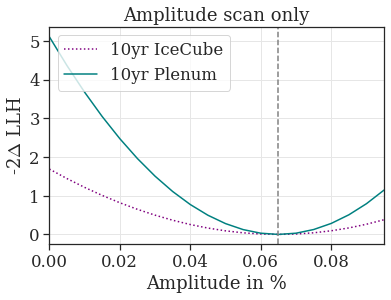

In [11]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0, 0.1, step=0.005)
astro_scaling = np.atleast_1d(1) # np.linspace(0.91, 1.03, 30) # 
g_scaling = np.atleast_1d(1) # np.linspace(0.99, 1.01, 25)
gamma_astro_scaling = gamma_astro * g_scaling


llh_global_min = dict()
llh_scan_min = dict()
astro_nuis = dict()
gamma_nuis = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]



    k_i = ((astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev * uni) * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

    llh_s = np.zeros((len(gamma_astro_scaling), len(A_scaling), len(astro_scaling)))

    for jj, gsc in enumerate(gamma_astro_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_astro_scaling))
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gsc) * phi_astro, 0, 2)
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        llh_s[jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )

    # index at best fit
    iag, iam, ias = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("Amplitude best-fit", A_scaling[iam])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s = np.moveaxis(llh_s, -1, 0)

    llh_global_min[label] = np.min(llh_s) # global minimum
    llh_scan_min[label] = np.min(llh_s.reshape(-1, llh_s.shape[-1]), axis=0) # minimum per amplitude scanning point

f, ax = plt.subplots()

for label in ["10yr IceCube", "10yr Plenum"]:
    ax.plot(
        A_scaling,
        llh_scan_min[label] - llh_global_min[label],
        label=label,
        **plot_sets[label]
    )
    
ax.axvline(A_base, color="gray", ls="--")
ax.legend(loc=2)

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.set_title("Amplitude scan only")

In [12]:
llh_s = 0
k_i = 0
tmp_astro = 0
all_mu_i = 0

## Amplitude scan, and phi_astro as nuisance

10yr IceCube
total events with dipole: 405666851.3856314
conv events: 673591.4001333234
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Amplitude best-fit 0.065
Phi scaling best-fit 1.0010344827586208
gamma best-fit -2.37
10yr Plenum
total events with dipole: 1630691088.4549468
conv events: 2707574.963516162
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Amplitude best-fit 0.065
Phi scaling best-fit 1.0010344827586208
gamma best-fit -2.37


Text(0.5, 1.0, 'Amplitude scan + $\\Phi_0^{\\rm astro}$ nuisance')

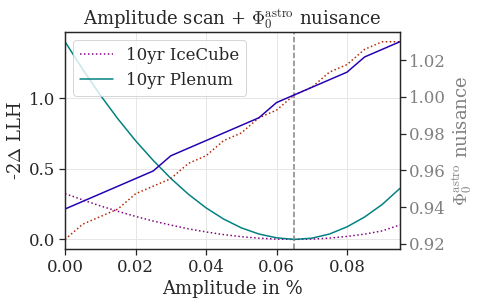

In [13]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0, 0.1, step=0.005)
astro_scaling = np.linspace(0.91, 1.03, 30) # 
g_scaling = np.atleast_1d(1) # np.linspace(0.99, 1.01, 25)
gamma_astro_scaling = gamma_astro * g_scaling


llh_global_min = dict()
llh_scan_min = dict()
astro_nuis = dict()
gamma_nuis = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]



    k_i = ((astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev * uni) * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

    llh_s = np.zeros((len(gamma_astro_scaling), len(A_scaling), len(astro_scaling)))

    for jj, gsc in enumerate(gamma_astro_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_astro_scaling))
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gsc) * phi_astro, 0, 2)
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        llh_s[jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )
    tmp_astro = 0
    all_mu_i = 0
    k_i = 0

    # index at best fit
    iag, iam, ias = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("Amplitude best-fit", A_scaling[iam])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s = np.moveaxis(llh_s, -1, 0)

    llh_global_min[label] = np.min(llh_s) # global minimum
    llh_scan_min[label] = np.min(llh_s.reshape(-1, llh_s.shape[-1]), axis=0) # minimum per amplitude scanning point

    # get bf nuisance parameters
    prf_ind_asc, prf_ind_gsc = np.unravel_index(np.argmin(llh_s.reshape(-1, llh_s.shape[-1]), axis=0), shape=llh_s.shape[:2])
    astro_nuis[label] = astro_scaling[prf_ind_asc]
    gamma_nuis[label] = g_scaling[prf_ind_gsc]

f, ax = plt.subplots()

ax2 = ax.twinx()
ax2.set_ylabel(r"$\Phi_0^{\rm astro}$ nuisance", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.grid(False)

for label in ["10yr IceCube", "10yr Plenum"]:
    ax.plot(
        A_scaling,
        llh_scan_min[label] - llh_global_min[label],
        label=label,
        **plot_sets[label]
    )
    ax2.plot(
        A_scaling,
        astro_nuis[label],
        color=slightly_change_color(plot_sets[label]["color"]),
        ls=plot_sets[label]["ls"]
    )
    
ax.axvline(A_base, color="gray", ls="--")
ax.legend(loc=2)

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")

In [14]:
llh_s = 0
k_i = 0
tmp_astro = 0
all_mu_i = 0

## what amplitude could be visible?

## with astro scaling

In [25]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0.02, 0.25, step=0.01)
astro_scaling = np.linspace(0.7, 1.1, 40) # 

llh_ratio = dict()
phi_s_bf = dict()
phi_b_bf = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]

    k_i = (astro_ev * ((1 - A_scaling) * uni + A_scaling * dipole) + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))
    
    
    tmp_astro = astro_ev.copy()
    tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
    
    all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    bg_mu_i = tmp_astro * uni[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    
    llh_s = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    all_mu_i = 0
    llh_b = -2 * np.sum(
        np.where(
            bg_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(bg_mu_i) - bg_mu_i,
            0
        ).reshape(-1, *np.shape(bg_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    bg_mu_i = 0
    k_i = 0
    phi_s_bf[label] = astro_scaling[llh_s.argmin(axis=1)]
    phi_b_bf[label] = astro_scaling[llh_b.argmin(axis=1)]
    print("Phi signal scaling best-fit", phi_s_bf[label])
    print("Phi bckg scaling best-fit", phi_b_bf[label])

    llh_ratio[label] = np.min(llh_s, axis=-1) - np.min(llh_b, axis=-1)
    llh_s = 0
    llh_b = 0

10yr IceCube
total events with dipole: 621829902.5385523
conv events: 673591.4001333234
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Phi signal scaling best-fit [0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359]
Phi bckg scaling best-fit [0.97692308 0.96666667 0.95641026 0.94615385 0.92564103 0.91538462
 0.90512821 0.89487179 0.88461538 0.87435897 0.86410256 0.84358974
 0.83333333 0.82307692 0.81282051 0.8025641  0.79230769 0.78205128
 0.76153846 0.75128205 0.74102564 0.73076923 0.72051282]
10yr Plenum
total events with dipole: 2499775003.153093
conv events: 2707574.963516162
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Phi signal scaling best-fit [0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.997

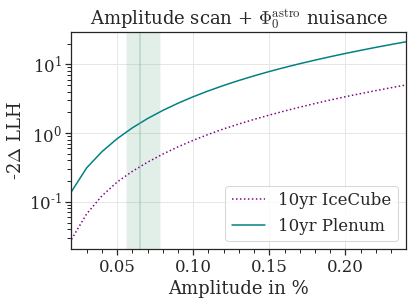

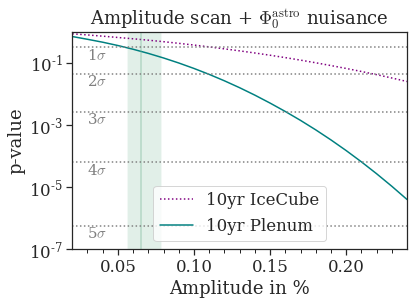

In [31]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.savefig("plots/dipole_combined_amp_astro_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.savefig("plots/dipole_combined_amp_astro_pval.pdf")

In [24]:
for i in range(5):
    print(i+1, 1-erf((i+1)/np.sqrt(2)))

1 0.31731050786291415
2 0.04550026389635842
3 0.002699796063260207
4 6.334248366623996e-05
5 5.733031437360481e-07


## without astro scaling

In [32]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0.02, 0.2, step=0.01)
astro_scaling = np.atleast_1d(1) #np.linspace(0.9, 1.1, 30) # 

llh_ratio = dict()
phi_s_bf = dict()
phi_b_bf = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]

    k_i = (astro_ev * ((1 - A_scaling) * uni + A_scaling * dipole) + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))
    
    
    tmp_astro = astro_ev.copy()
    tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
    
    all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    bg_mu_i = tmp_astro * uni[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    
    llh_s = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    all_mu_i = 0
    llh_b = -2 * np.sum(
        np.where(
            bg_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(bg_mu_i) - bg_mu_i,
            0
        ).reshape(-1, *np.shape(bg_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    bg_mu_i = 0
    phi_s_bf[label] = astro_scaling[llh_s.argmin(axis=1)]
    phi_b_bf[label] = astro_scaling[llh_b.argmin(axis=1)]
    print("Phi signal scaling best-fit", phi_s_bf[label])
    print("Phi bckg scaling best-fit", phi_b_bf[label])

    llh_ratio[label] = np.min(llh_s, axis=-1) - np.min(llh_b, axis=-1)
    llh_s = 0
    llh_b = 0

10yr IceCube
total events with dipole: 12167686.57665298
conv events: 673591.4001333234
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Phi signal scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Phi bckg scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
10yr Plenum
total events with dipole: 48913291.861273415
conv events: 2707574.963516162
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Phi signal scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Phi bckg scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


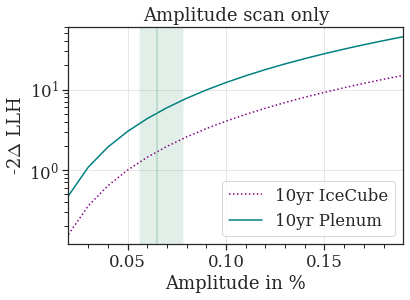

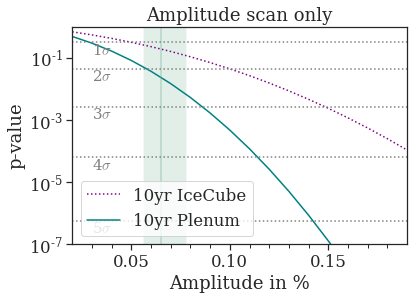

In [33]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan only")
f.savefig("plots/dipole_combined_amp_only_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan only")
f.savefig("plots/dipole_combined_amp_only_pval.pdf")